In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Classifying Names with a Character-Level RNN
==============================================================

**Author**: [Sean Robertson](https://github.com/spro)

We will be building and training a basic character-level Recurrent
Neural Network (RNN) to classify words. This tutorial, along with two
other Natural Language Processing (NLP) \"from scratch\" tutorials
`/intermediate/char_rnn_generation_tutorial`{.interpreted-text
role="doc"} and
`/intermediate/seq2seq_translation_tutorial`{.interpreted-text
role="doc"}, show how to preprocess data to model NLP. In particular
these tutorials do not use many of the convenience functions of
[torchtext]{.title-ref}, so you can see how preprocessing to model NLP
works at a low level.

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

``` {.sourceCode .sh}
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

Recommended Preparation
-----------------------

Before starting this tutorial it is recommended that you have installed
PyTorch, and have a basic understanding of Python programming language
and Tensors:

-   <https://pytorch.org/> For installation instructions
-   `/beginner/deep_learning_60min_blitz`{.interpreted-text role="doc"}
    to get started with PyTorch in general and learn the basics of
    Tensors
-   `/beginner/pytorch_with_examples`{.interpreted-text role="doc"} for
    a wide and deep overview
-   `/beginner/former_torchies_tutorial`{.interpreted-text role="doc"}
    if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

Preparing the Data
------------------

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>Download the data from<a href="https://download.pytorch.org/tutorial/data.zip">here</a>and extract it to the current directory.</p>
</div>

Included in the `data/names` directory are 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We\'ll end up with a dictionary of lists of names per language,
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.


In [2]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data_char_RNN/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data_char_RNN/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data_char_RNN/data/names/Arabic.txt', 'data_char_RNN/data/names/Chinese.txt', 'data_char_RNN/data/names/Czech.txt', 'data_char_RNN/data/names/Dutch.txt', 'data_char_RNN/data/names/English.txt', 'data_char_RNN/data/names/French.txt', 'data_char_RNN/data/names/German.txt', 'data_char_RNN/data/names/Greek.txt', 'data_char_RNN/data/names/Irish.txt', 'data_char_RNN/data/names/Italian.txt', 'data_char_RNN/data/names/Japanese.txt', 'data_char_RNN/data/names/Korean.txt', 'data_char_RNN/data/names/Polish.txt', 'data_char_RNN/data/names/Portuguese.txt', 'data_char_RNN/data/names/Russian.txt', 'data_char_RNN/data/names/Scottish.txt', 'data_char_RNN/data/names/Spanish.txt', 'data_char_RNN/data/names/Vietnamese.txt']
Slusarski


Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very \"pure\" way,
as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users
tutorial \<https://pytorch.org/tutorials/beginner/former\_torchies/
nn\_tutorial.html\#example-2-recurrent-net\>]{.title-ref}\_\_) is just 2
linear layers which operate on an input and hidden state, with a
`LogSoftmax` layer after the output.


In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_device(device)
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:1


In [59]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined).to(device)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn.to(device)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [60]:
print(device)
input1 = letterToTensor('A').to(device)
hidden = torch.zeros(1, n_hidden).to(device)
output, next_hidden = rnn(input1, hidden)
print(output, next_hidden)

cuda:1
tensor([[-2.8794, -2.9339, -2.9148, -2.9187, -2.9089, -2.8105, -2.8792, -2.8915,
         -2.8977, -2.9083, -2.8097, -2.9586, -2.9122, -2.8700, -2.9100, -2.8627,
         -2.8508, -2.9235]], device='cuda:1', grad_fn=<LogSoftmaxBackward>) tensor([[-0.0130,  0.0372,  0.0280,  0.0063, -0.0331, -0.0487, -0.0227, -0.0628,
          0.0637,  0.0402,  0.0251,  0.0669,  0.0728,  0.0015,  0.0972,  0.0618,
          0.0041,  0.0705,  0.1103,  0.0481, -0.0216,  0.0741,  0.0416,  0.0226,
         -0.0600, -0.0579,  0.0781,  0.0152,  0.1075,  0.0665,  0.0341, -0.0470,
          0.0401, -0.0221, -0.0217, -0.0107, -0.0356,  0.0253,  0.0028,  0.0576,
         -0.0279, -0.0149, -0.0433,  0.0442,  0.0318, -0.0094,  0.0466,  0.0411,
          0.0132,  0.0325, -0.0214, -0.0065, -0.0386,  0.0866,  0.0214, -0.0495,
         -0.0598,  0.0405, -0.0278, -0.0168, -0.0774,  0.0601, -0.0553, -0.0539,
          0.0014, -0.0201, -0.0825,  0.0549, -0.0628, -0.1220, -0.0491, -0.0650,
          0.0294, -0.0673,

For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [61]:
input = lineToTensor('Albert').to(device)
hidden = torch.zeros(1, n_hidden).to(device)

for i in range(input.size()[0]):
    output, hidden = rnn(input[i], hidden)
    
print(output)

tensor([[-2.8964, -2.9891, -2.9503, -2.8533, -2.9279, -2.8033, -2.8384, -2.9082,
         -2.9400, -2.8469, -2.7663, -2.9586, -2.8870, -2.8743, -2.9958, -2.8601,
         -2.8239, -2.9423]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [62]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


We will also want a quick way to get a training example (a name and its
language):


In [67]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line).to(device)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Madden
category = Vietnamese / line = Thao
category = Greek / line = Bekyros
category = Arabic / line = Nader
category = French / line = Bonner
category = Vietnamese / line = Diep
category = German / line = Moser
category = English / line = Steward
category = Vietnamese / line = Tong
category = Scottish / line = Watt


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the RNN is `nn.LogSoftmax`.


In [68]:
criterion = nn.NLLLoss()

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [69]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [70]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 3.0525 Daele / English ✗ (Dutch)
10000 10% (0m 34s) 1.6706 De santigo / Italian ✗ (Portuguese)
15000 15% (0m 51s) 0.4367 Voltolini / Italian ✓
20000 20% (1m 7s) 2.1462 Porcher / German ✗ (French)
25000 25% (1m 24s) 0.5327 Amadei / Italian ✓
30000 30% (1m 41s) 4.4328 Krau / Vietnamese ✗ (German)
35000 35% (1m 57s) 0.3856 Nassar / Arabic ✓
40000 40% (2m 14s) 2.2650 Rocha / Czech ✗ (Portuguese)
45000 45% (2m 31s) 3.5097 Kneib / Arabic ✗ (German)
50000 50% (2m 47s) 0.0247 Crocetti / Italian ✓
55000 55% (3m 4s) 0.6080 Cremaschi / Italian ✓
60000 60% (3m 21s) 1.8321 Turchi / Japanese ✗ (Italian)
65000 65% (3m 38s) 2.3098 Mann / Chinese ✗ (German)
70000 70% (3m 55s) 1.5755 Abeln / Dutch ✗ (German)
75000 75% (4m 12s) 0.2498 Slootmaekers / Dutch ✓
80000 80% (4m 29s) 0.0640 Asghar / Arabic ✓
85000 85% (4m 46s) 0.6409 Thi / Vietnamese ✓
90000 90% (5m 3s) 0.0392 Protopsaltis / Greek ✓
95000 95% (5m 20s) 3.6455 Gentile / French ✗ (Italian)
100000 100% (5m 37s) 2.3843 Phan / Irish ✗

Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


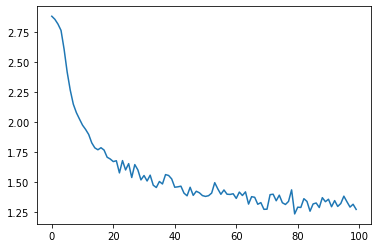

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


/opt/anaconda/envs/wmlce/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda/envs/wmlce/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


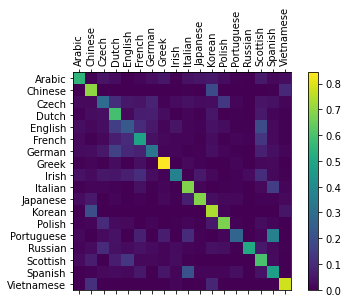

In [72]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [75]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).to(device))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.47) Czech
(-1.92) English
(-2.09) Russian

> Jackson
(-0.87) Scottish
(-1.47) Dutch
(-1.69) English

> Satoshi
(-0.76) Italian
(-1.70) Polish
(-1.93) Chinese


The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)
split the above code into a few files:

-   `data.py` (loads files)
-   `model.py` (defines the RNN)
-   `train.py` (runs training)
-   `predict.py` (runs `predict()` with command line arguments)
-   `server.py` (serve prediction as a JSON API with `bottle.py`)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions:

``` {.sourceCode .sh}
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit <http://localhost:5533/Yourname> to get JSON
output of predictions.


Exercises
=========

-   Try with a different dataset of line -\> category, for example:
    -   Any word -\> language
    -   First name -\> gender
    -   Character name -\> writer
    -   Page title -\> blog or subreddit
-   Get better results with a bigger and/or better shaped network
    -   Add more linear layers
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network


In [50]:
t1 = torch.arange(1, 10)
t11 = torch.clone(t1).to(device)
t1.to(device)
print(t11.device)
t2 = torch.arange(10, 20)
t2.to(device)
print(t2.device)
t22 = torch.clone(t2).to(device)
t3= torch.cat((t11,t22), 0)
t3.to(device)
print(t3.device)

cuda:1
cpu
cuda:1
